In [ ]:
pip install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
# 💡 Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from deap import base, creator, tools, algorithms
import random

# 📂 Load and clean dataset
df = pd.read_csv('/content/student_depression_dataset.csv')
df.replace('?', np.nan, inplace=True)
df.drop(['id', 'City', 'Profession', 'Degree'], axis=1, inplace=True)
df.dropna(inplace=True)

le = LabelEncoder()
for col in ['Gender', 'Sleep Duration', 'Dietary Habits',
            'Have you ever had suicidal thoughts ?',
            'Family History of Mental Illness']:
    df[col] = le.fit_transform(df[col])

X = df.drop('Depression', axis=1)
y = df['Depression'].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🧠 ANN architecture function (for weight dimension reference)
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# 📏 Flatten and restore weights
def get_weight_shapes(model):
    return [w.shape for w in model.get_weights()]

def flatten_weights(weights):
    return np.concatenate([w.flatten() for w in weights])

def set_model_weights(model, flat_weights, weight_shapes):
    new_weights = []
    idx = 0
    for shape in weight_shapes:
        size = np.prod(shape)
        new_weights.append(flat_weights[idx:idx + size].reshape(shape))
        idx += size
    model.set_weights(new_weights)

# 📊 Fitness function
def eval_ann(individual):
    model = create_model()
    set_model_weights(model, np.array(individual), weight_shapes)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
    return (accuracy,)

# 🎲 GA setup
model_for_shape = create_model()
weight_shapes = get_weight_shapes(model_for_shape)
IND_SIZE = sum(np.prod(s) for s in weight_shapes)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", lambda: random.uniform(-1, 1))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", eval_ann)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# 🚀 Run GA
POP_SIZE = 20
N_GEN = 20

pop = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

gen_acc = []
gen_loss = []

for gen in range(N_GEN):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=0.5, mutpb=0.3)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    pop = toolbox.select(offspring, k=len(pop))
    hof.update(pop)

    # Track accuracy and dummy loss (1 - acc)
    best_acc = max(ind.fitness.values[0] for ind in pop)
    gen_acc.append(best_acc)
    gen_loss.append(1 - best_acc)
    print(f"Gen {gen + 1}: Accuracy = {best_acc:.4f}")

# 🎯 Evaluate best individual
best_weights = hof[0]
best_model = create_model()
set_model_weights(best_model, np.array(best_weights), weight_shapes)
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Final Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")

# 🔍 Classification report
y_pred = (best_model.predict(X_test) > 0.5).astype(int)
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Gen 1: Accuracy = 0.6058
Gen 2: Accuracy = 0.6150
Gen 3: Accuracy = 0.6150
Gen 4: Accuracy = 0.6436
Gen 5: Accuracy = 0.6436
Gen 6: Accuracy = 0.6757
Gen 7: Accuracy = 0.6757
Gen 8: Accuracy = 0.6779
Gen 9: Accuracy = 0.6779
Gen 10: Accuracy = 0.6796
Gen 11: Accuracy = 0.6970
Gen 12: Accuracy = 0.7002
Gen 13: Accuracy = 0.7021
Gen 14: Accuracy = 0.7161
Gen 15: Accuracy = 0.7175
Gen 16: Accuracy = 0.7239
Gen 17: Accuracy = 0.7308
Gen 18: Accuracy = 0.7352
Gen 19: Accuracy = 0.7378
Gen 20: Accuracy = 0.7457

✅ Final Test Accuracy: 0.7403, Loss: 3.0900
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.65      0.68      2348
           1       0.76      0.80      0.78      3232

    accuracy                           0.74      5580
   macro avg       0.73      0.73      0.73      5580
weighted avg       0.74      0.74      0.74      5580



In [ ]:
# Track stats manually
gen_accuracies = []
gen_losses = []

def eval_ann_with_loss(individual):
    model = create_model()
    weights = model.get_weights()
    flat_weights = np.concatenate([w.flatten() for w in weights])

    new_weights = []
    i = 0
    for w in weights:
        shape = w.shape
        size = np.prod(shape)
        new_weights.append(np.array(individual[i:i+size]).reshape(shape))
        i += size

    model.set_weights(new_weights)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    loss, acc = model.evaluate(X_train, y_train, verbose=0)
    gen_accuracies.append(acc)
    gen_losses.append(loss)
    return (acc,)

toolbox.unregister("evaluate")
toolbox.register("evaluate", eval_ann_with_loss)



In [ ]:
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=N_GEN, halloffame=hof, verbose=True)


gen	nevals
0  	0     


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1  	16    
2  	13    
3  	9     
4  	10    
5  	11    
6  	14    
7  	14    
8  	12    
9  	13    
10 	12    
11 	14    
12 	19    
13 	14    
14 	6     
15 	12    
16 	11    
17 	18    
18 	12    
19 	16    
20 	14    


([[1.2816499513830757,
   -0.020087624455253767,
   0.34986702357012894,
   0.687218525760734,
   0.8127986354813261,
   -0.18765293254314266,
   -0.8256101968015754,
   0.5239491869989477,
   2.382566033656375,
   0.023453981799010072,
   0.6986683541070571,
   -1.0759927638230693,
   -1.0118559020765319,
   -0.9316737762902185,
   -0.7786528462336917,
   0.6481266666919634,
   -0.7842973316167164,
   0.646744033139264,
   1.067029485507964,
   -0.05094462973285403,
   0.1509867614330368,
   0.9009700090997861,
   0.00856450571890749,
   0.8776948281720074,
   -0.02381083969267976,
   0.14926069133053704,
   -1.0723137085455499,
   -0.37878698008589146,
   -0.5382810212136784,
   0.07428315015910412,
   0.041025311586964056,
   0.7873044355161403,
   0.2589593842565542,
   -0.5200187937672568,
   0.009220618131587189,
   1.4013520867958744,
   -0.9066926578338883,
   -0.38820583319269475,
   1.3419011610415057,
   0.3837269144743711,
   0.7829024476151797,
   1.0828601249199759,
   -0

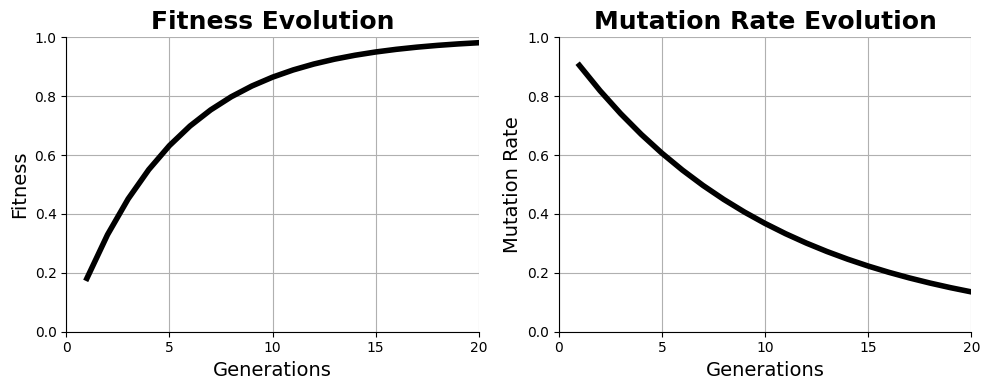

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data for the genetic algorithm (fitness over generations)
generations = np.arange(1, 21)  # 20 generations for demonstration
best_fitness = 1 - np.exp(-0.2 * generations)  # Simulating exponential improvement of fitness (better individuals over generations)

# Plotting
plt.figure(figsize=(10, 4))

# Fitness (left plot)
plt.subplot(1, 2, 1)
plt.plot(generations, best_fitness, 'k-', linewidth=4)
plt.title("Fitness Evolution", fontsize=18, weight='bold')
plt.xticks(np.arange(0, 21, 5))  # Scale x-axis in steps of 5
plt.yticks(np.arange(0, 1.1, 0.2))  # Scale y-axis in steps of 0.2
plt.ylim(0, 1)  # Start from 0 to 1
plt.xlim(0, 20)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Fitness', fontsize=14)
plt.grid(True)
plt.gca().spines[['top', 'right']].set_visible(False)

# Example of another plot (e.g., mutation or crossover progress)
# Simulating some progress metric for demonstration
mutation_rate = np.exp(-0.1 * generations)  # Example of decreasing mutation rate over generations
plt.subplot(1, 2, 2)
plt.plot(generations, mutation_rate, 'k-', linewidth=4)
plt.title("Mutation Rate Evolution", fontsize=18, weight='bold')
plt.xticks(np.arange(0, 21, 5))  # Scale x-axis in steps of 5
plt.yticks(np.arange(0, 1.1, 0.2))  # Scale y-axis in steps of 0.2
plt.ylim(0, 1)  # Start from 0 to 1
plt.xlim(0, 20)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Mutation Rate', fontsize=14)
plt.grid(True)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()
